# Neurovault: what is the variance, where is it, what are the components? #

### Steps to follow ###
* PCA
* ICA
* canICA
* Dictionary learning

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import nibabel
import os
from os.path import join as pjoin
from glob import glob
import pandas as pd
from pandas.io.json import json_normalize
import pickle as pk
from nilearn.input_data import NiftiMasker
from nilearn._utils import check_niimg
from sklearn.decomposition import PCA
from nilearn.plotting import plot_stat_map
from nilearn.image import new_img_like
from nilearn import datasets
from sklearn.externals.joblib import Memory
from nilearn.decomposition import DictLearning, CanICA

In [2]:
data_folder = os.path.expanduser('~/nilearn_data/neurovault')
results_folder = 'results'

if not os.path.exists(results_folder):
    os.mkdir(results_folder)

In [3]:
files = glob(pjoin(data_folder,'*','*.nii.gz'))
# Masker parameters: here we use a MNI 152 mask with 3mm resolution
mask_img = pjoin(data_folder, 'MNI152_T1_3mm_brain_mask.nii.gz')
target_img = nibabel.load(mask_img)
masker = NiftiMasker(mask_img=mask_img, smoothing_fwhm=2, standardize=False,
                     target_affine=target_img.affine, target_shape=target_img.shape,
                     memory='nilearn_cache')
masker = masker.fit()

In [4]:
files_dataset = {}
for f in files:
    f_split = f.split(os.sep)
    image_ind = f_split[-2]
    image_name = f_split[-1]
    files_dataset.setdefault('image_ind', []).append(int(image_ind))
    files_dataset.setdefault('image_name', []).append(image_name)
    files_dataset.setdefault('file_name', []).append(f)
    
files_dataset = pd.DataFrame(files_dataset)

In [5]:
import json
# getting the metadata, here we are only selecting a few keys.
def _add_metadata(row):
    f_split = row.file_name.split(os.sep)
    path = os.sep.join(f_split[:-1])
    img = f_split[-1].split('.nii')[0]
    file_name = pjoin(path, img + '.nii_metadata.json')
    row['metadata'] = file_name
    try: 
        info = json.load(open(file_name))
        row['map_type'] = info['map_type']
        row['cognitive_contrast_cogatlas'] = info.get('cognitive_contrast_cogatlas', 'N/A')
        row['is_thresholded'] = info.get('is_thresholded', 'N/A')
        row['not_mni'] = info.get('not_mni', 'N/A')
    except: 
        row['map_type'] = 'N/A'
        row['cognitive_contrast_cogatlas'] = 'N/A'
        row['is_thresholded'] = 'N/A'
        row['not_mni'] = 'N/A'
        print 'problem: metadata file does not exists'
    return row

# Addidng metadata information
files_dataset = files_dataset.apply(_add_metadata, axis=1)

problem: metadata file does not exists


In [6]:
# removing the images that are not in MNI space
files_dataset = files_dataset[files_dataset['not_mni'].isin([False])]

In [7]:
# Data cleaning functions
def clean_img(niimg):
    niimg = check_niimg(niimg)
    niimg_data = niimg.get_data()
    niimg_data[np.isnan(niimg_data)] = 0
    niimg_data[np.isinf(niimg_data)] = 0
    return new_img_like(niimg, niimg_data)

In [8]:
def cast_img(niimg, dtype=np.float32):
    niimg = check_niimg(niimg)
    niimg_data = niimg.get_data().astype(dtype)
    return new_img_like(niimg, niimg_data)

In [9]:
X_ = []
not_working_images = []
niimg_ind = []
dataframe_ind = []
for row in files_dataset.iterrows():
    file_name = row[1]['file_name']
    niimg_ind.append(row[1]['image_ind'])
    dataframe_ind.append(row[0])
    niimg = cast_img(file_name)
    niimg = clean_img(niimg)
    try: 
        X_.append(masker.transform(file_name))
    except Exception as e:
        print 'something happened'
        not_working_images.append(row[1]['image_ind'])  
        
X = np.concatenate(X_, axis=0)
dataframe_ind = np.array(dataframe_ind )

In [10]:
# Removing images with high values
not_working_images = (X > 10000).any(axis=1)
X = X[~not_working_images]
dataframe_ind = dataframe_ind[~not_working_images]

### First analysis: PCA ###
We are going to test the componnets of the masked data.


In [11]:
path = pjoin(results_folder, 'pca_full.pkl')

if os.path.exists(path):
    pca_full = pk.load(open(path, 'rb'))
    X_pca_full = pca_full.transform(X)
else:
    pca_full = PCA(n_components=42)
    X_pca_full = pca_full.fit_transform(X)
    pk.dump(pca_full, open(path, 'wb'))

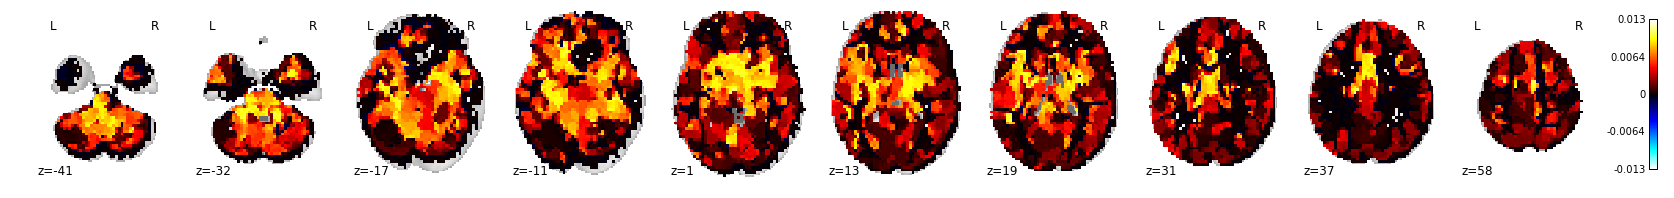

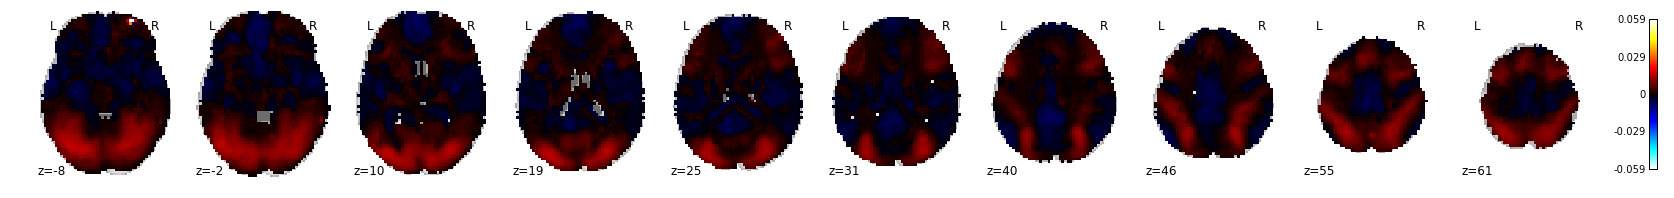

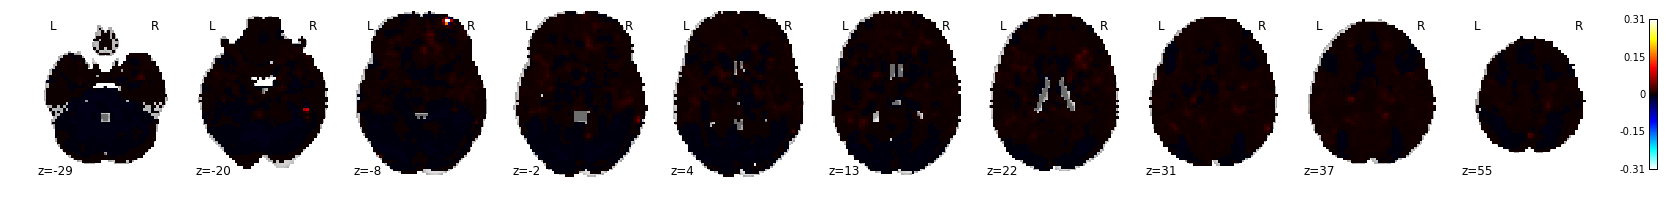

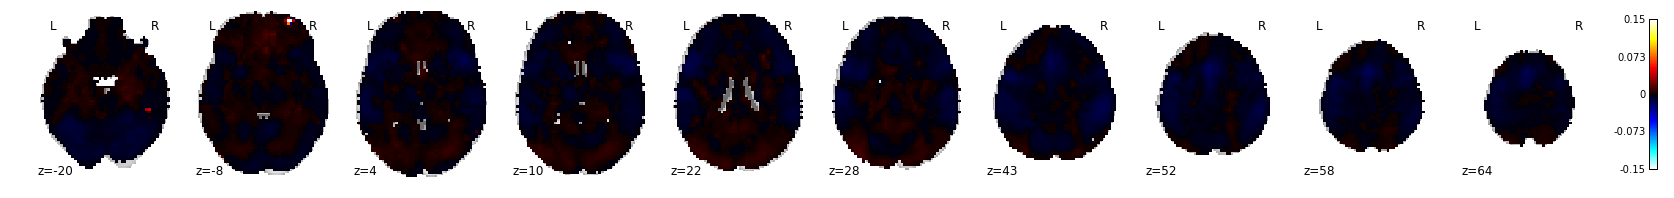

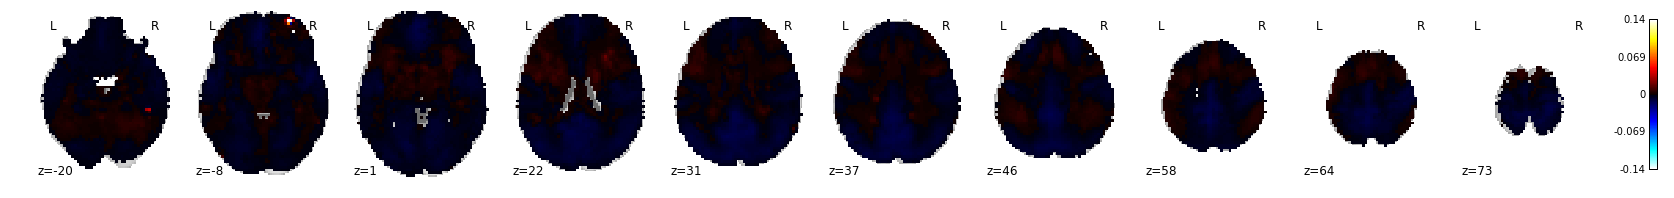

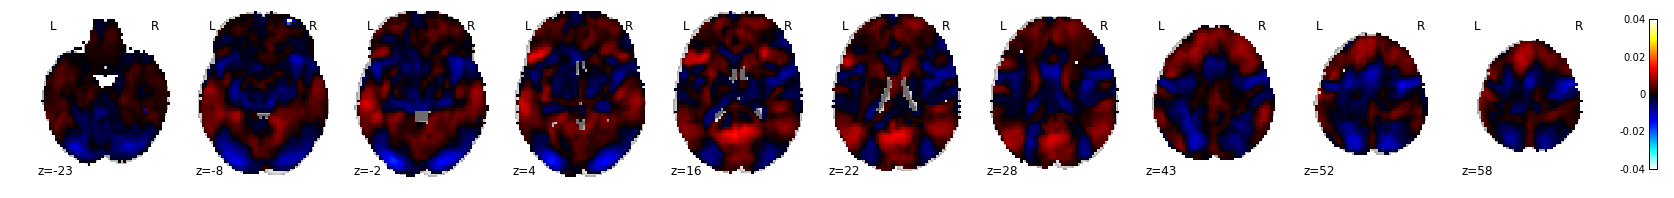

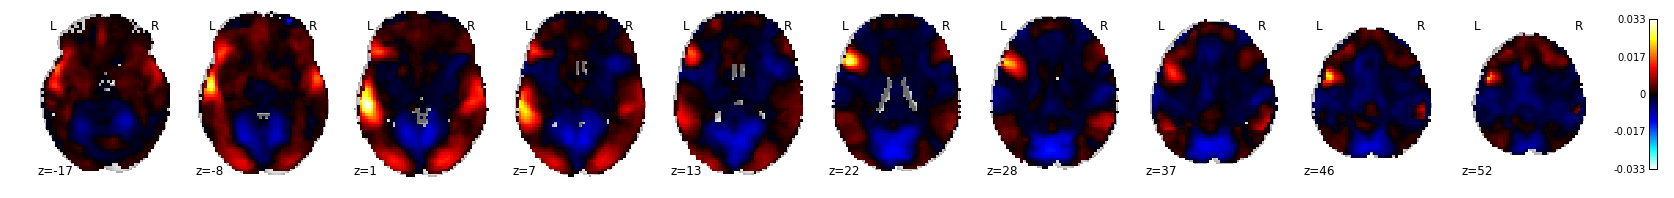

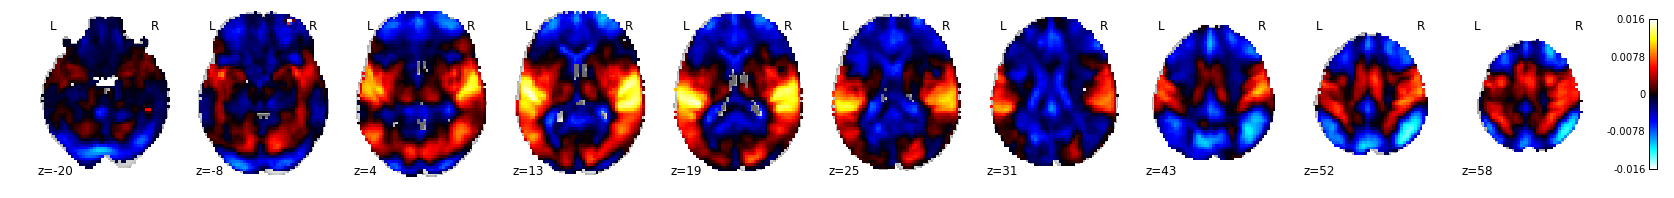

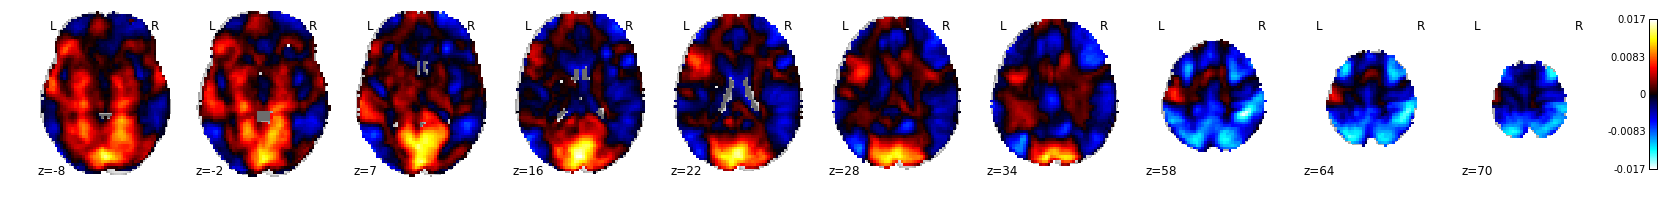

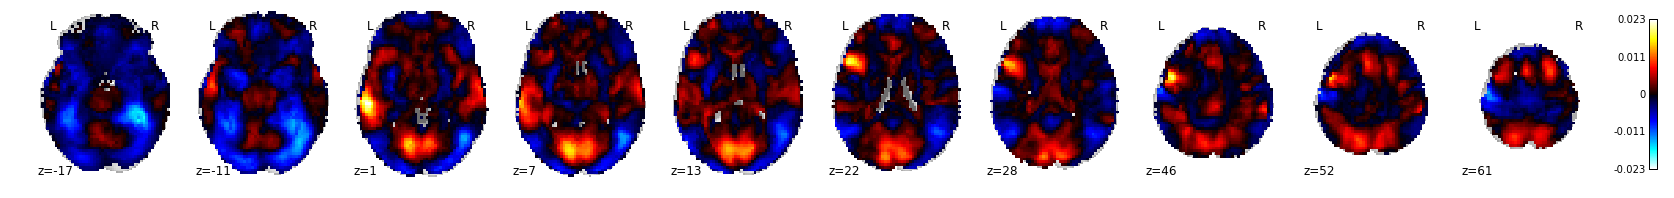

In [12]:
for i in range(10):
    plot_stat_map(masker.inverse_transform(pca_full.components_[i]), cut_coords=10, display_mode='z')

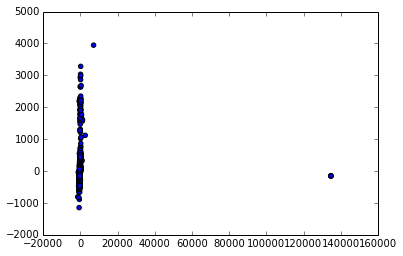

In [13]:
plt.scatter(*X_pca_full[:, :2].T)

Here we have primarly 2 outliers. Now, we are going to calculate the norm and plot it.

134669.34229


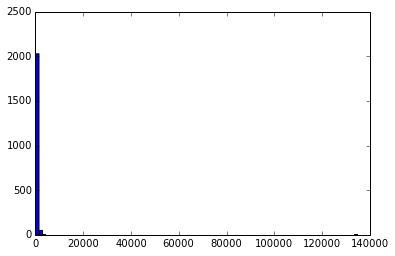

In [14]:
norms_full = np.linalg.norm(X_pca_full, axis=1)
a, b, h = plt.hist(norms_full, bins=100)
print norms_full.max()

In [15]:
# This values is set by hand
outlier_mask_0 = norms_full > 4e3
outlier_indices_0 = np.where(outlier_mask_0)[0]
inlier_indices_0 = np.where(~outlier_mask_0)[0]
print outlier_mask_0.shape, outlier_mask_0.sum(), outlier_indices_0, inlier_indices_0.shape
    
np.save(pjoin(results_folder, 'inlier_indices_0.npy'), inlier_indices_0)

(2101,) 7 [ 105  371 1348 1349 1350 1351 1446] (2094,)


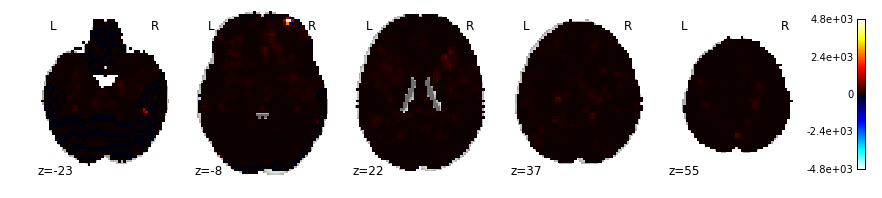

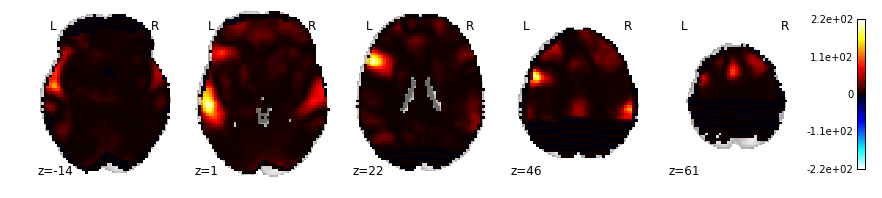

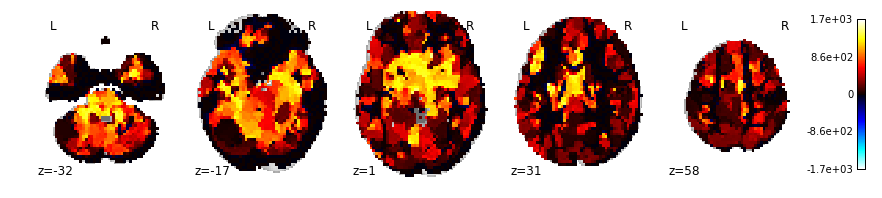

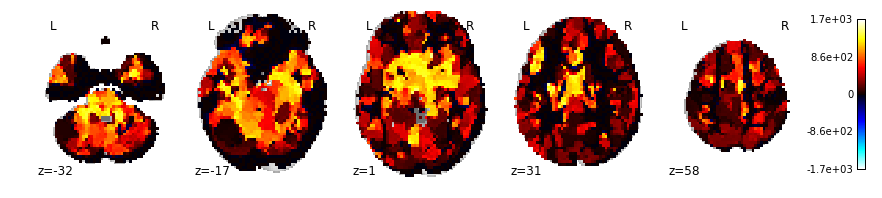

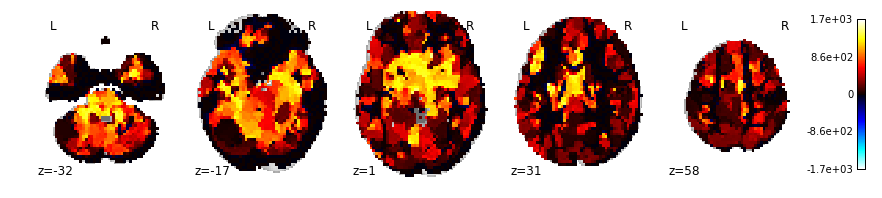

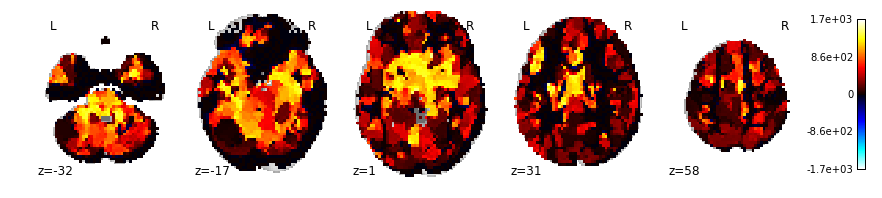

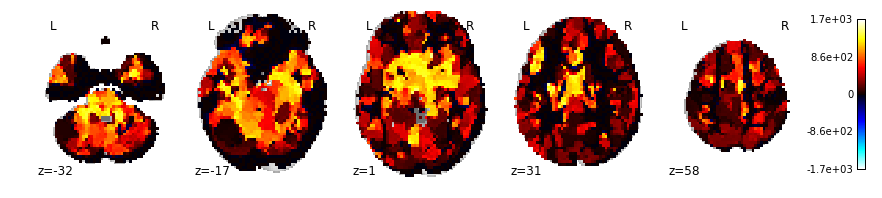

In [16]:
# Plotting the outliers
for i in outlier_indices_0:
    niimg = X[i]
    plot_stat_map(masker.inverse_transform(niimg), display_mode='z', cut_coords=5)

### Testing without the outliers ###
Now, we are going to remove these images and calculate the PCA again

In [17]:
# Cleaning the mem
del X_pca_full, pca_full

path = pjoin(results_folder, 'pca_0.pkl')

if os.path.exists(path):
    pca_0 = pk.load(open(path, 'rb'))
    X_pca_0 = pca_0.transform(X[inlier_indices_0])
else:
    pca_0 = PCA(n_components=42)
    X_pca_0 = pca_0.fit_transform(X[inlier_indices_0])
    pk.dump(pca_0, open(path, 'wb'))

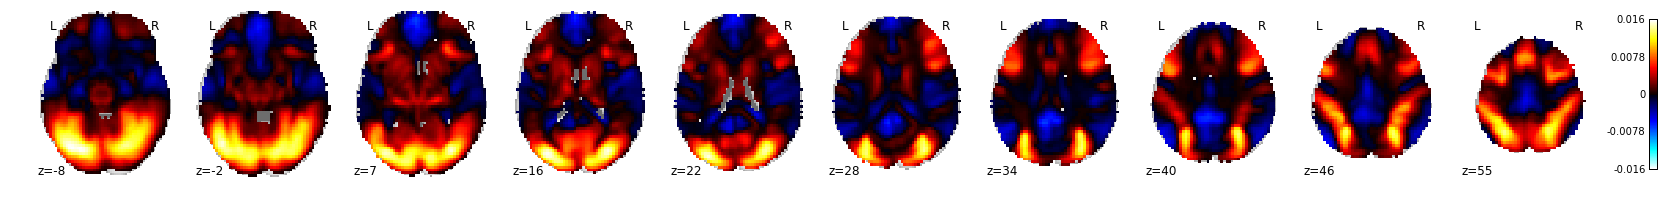

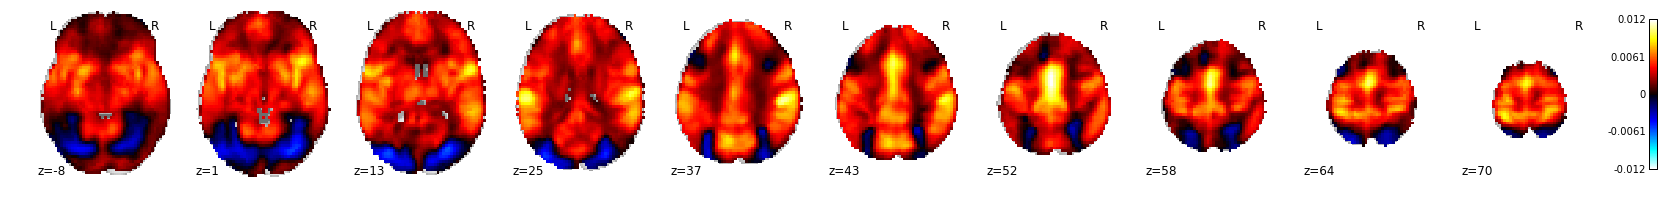

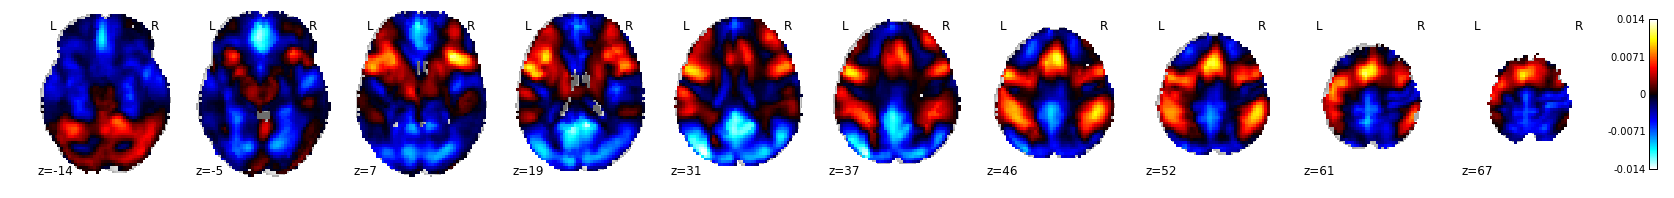

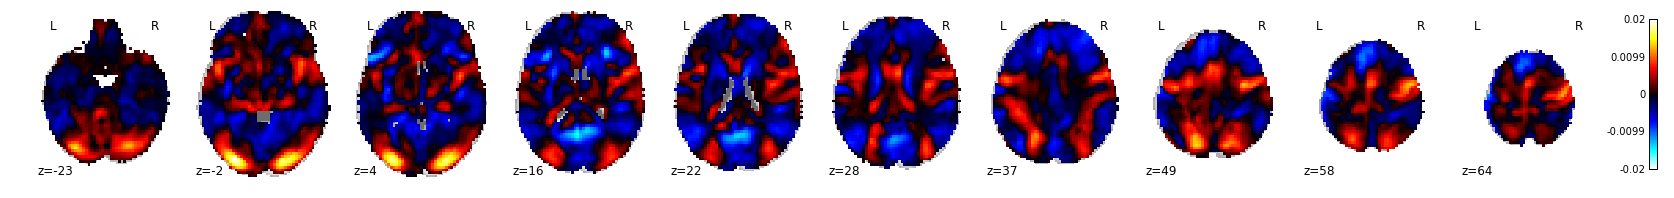

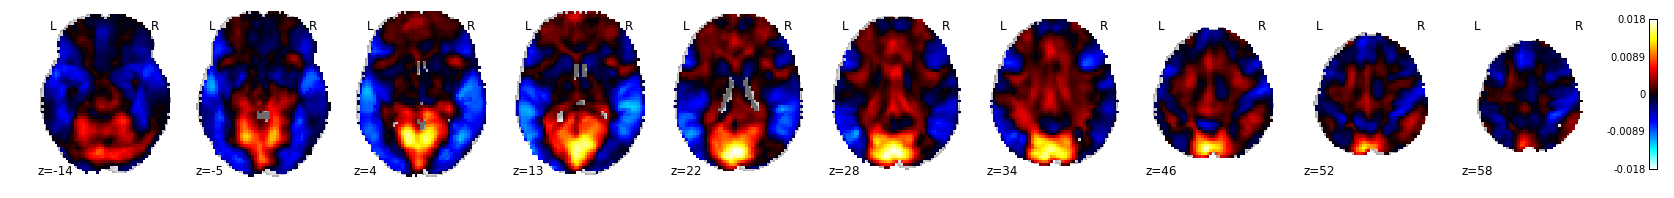

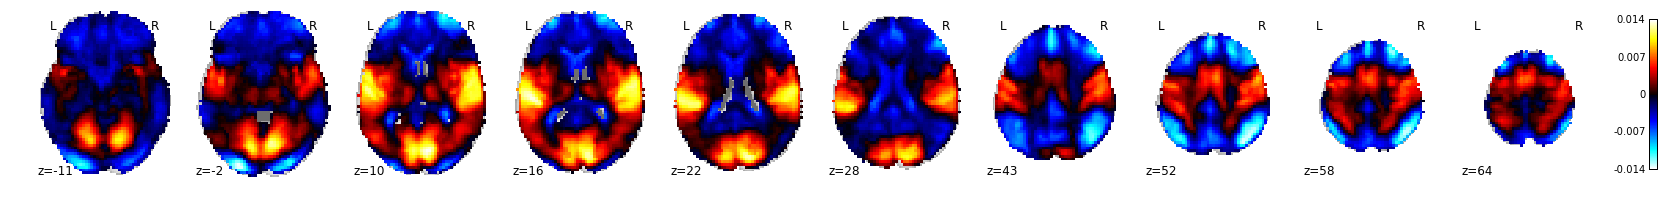

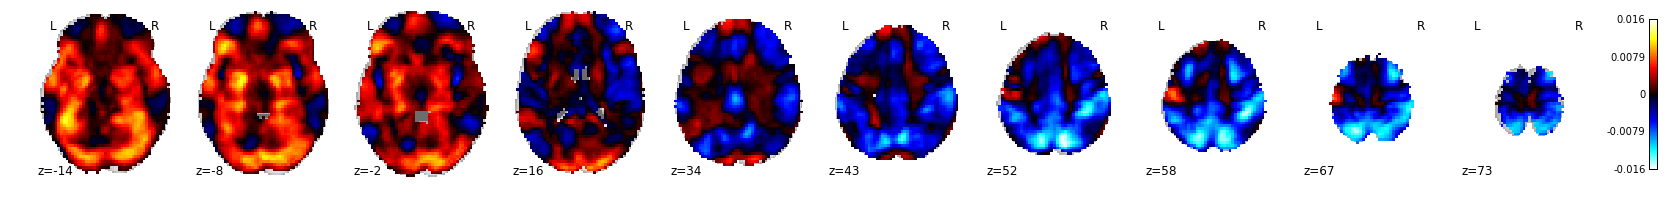

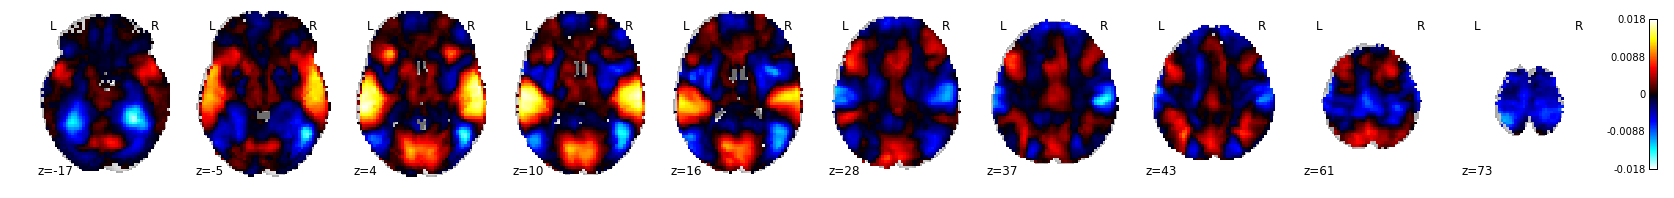

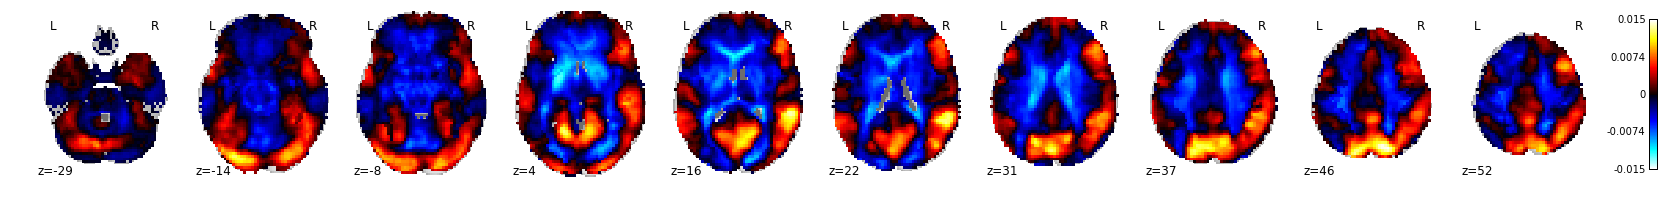

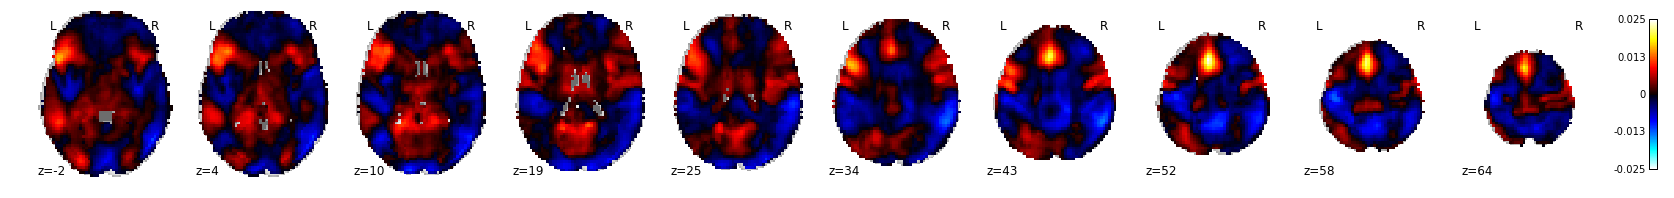

In [18]:
# Plotting the first 10 components
for i in range(10):
    plot_stat_map(masker.inverse_transform(pca_0.components_[i]), cut_coords=10, display_mode='z')

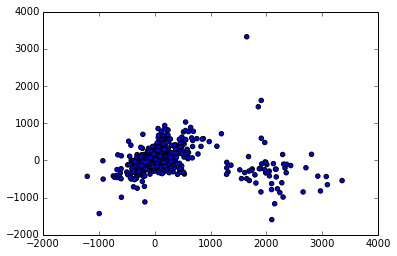

In [19]:
plt.scatter(*X_pca_0[:, :2].T)

We see two clusters, do they correspond to different type maps?

In [20]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2).fit(X_pca_0[:, :2])

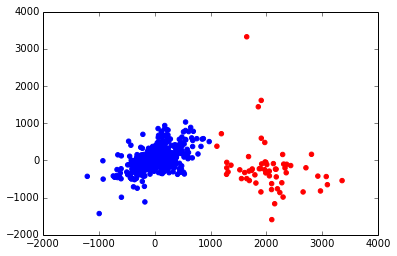

In [21]:
# Lets visualize the clusters
plt.scatter(*X_pca_0[:, :2].T, color=np.array(['b', 'r'])[kmeans.labels_])

In [22]:
unique_type_labels, type_labels = np.unique(files_dataset.map_type.values, return_inverse=True)
print unique_type_labels

[u'F map' u'T map' u'Z map']


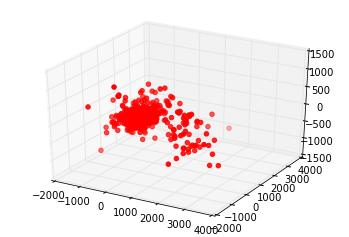

In [23]:
# Just testing a 3d plot
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x, y, z = X_pca_0[:, :3].T
ax.scatter(x, y, z, color=np.array(['b', 'm', 'r'])[type_labels])

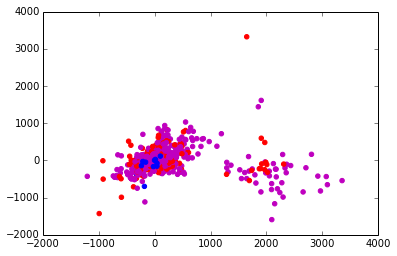

In [24]:
# Visualizing the map type
plt.scatter(*X_pca_0[:, :2].T, color=np.array(['b', 'm', 'r'])[type_labels])

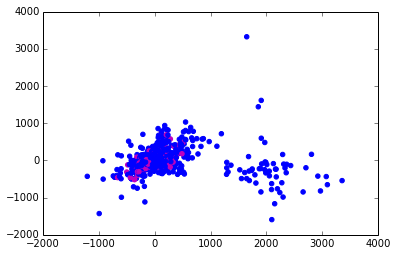

In [25]:
# Visualizing if is thresholded
n_thresholded, thresholded_labels = np.unique(files_dataset.is_thresholded.values, return_inverse=True)
plt.scatter(*X_pca_0[:, :2].T, color=np.array(['b', 'm'])[thresholded_labels])

<Container object of 50 artists>

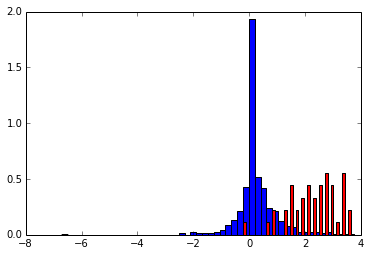

In [51]:
cl0 = np.mean(X[inlier_indices_0][kmeans.labels_ == 0], axis=1)
cl1 = np.mean(X[inlier_indices_0][kmeans.labels_ == 1], axis=1)

a, b, h = plt.hist(cl0, bins=50, normed=True)

a2, b2 = np.histogram(cl1, b, normed=True)
plt.bar(b2[:-1], a2, np.diff(b).mean()/2., color='r')

<Container object of 50 artists>

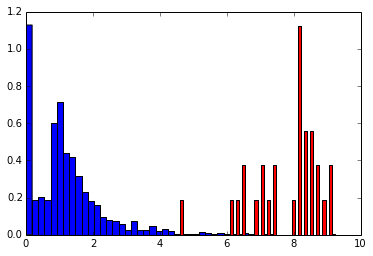

In [52]:
cl0 = np.std(X[inlier_indices_0][kmeans.labels_ == 0], axis=1)
cl1 = np.std(X[inlier_indices_0][kmeans.labels_ == 1], axis=1)

a, b, h = plt.hist(cl0, bins=50, normed=True)

a2, b2 = np.histogram(cl1, b, normed=True)
plt.bar(b2[:-1], a2, np.diff(b).mean()/2., color='r')

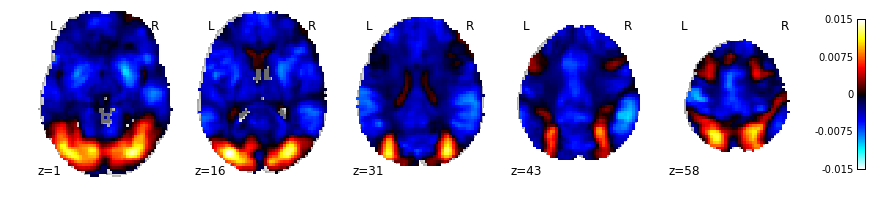

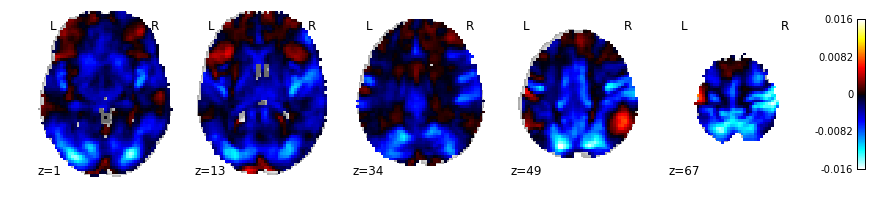

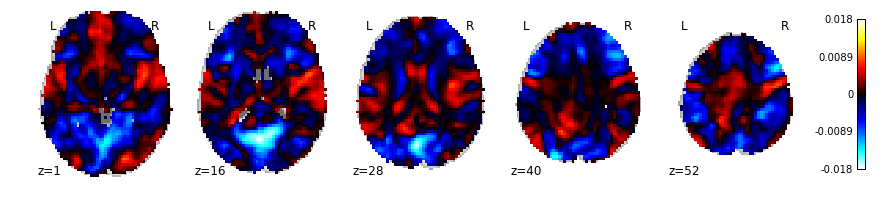

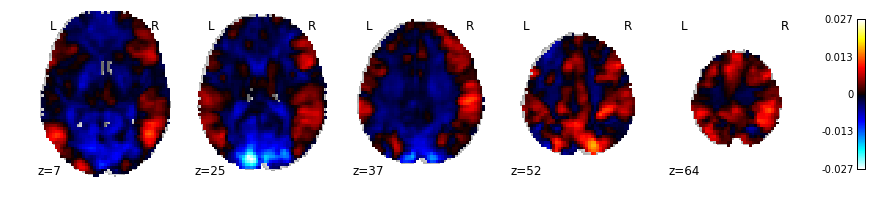

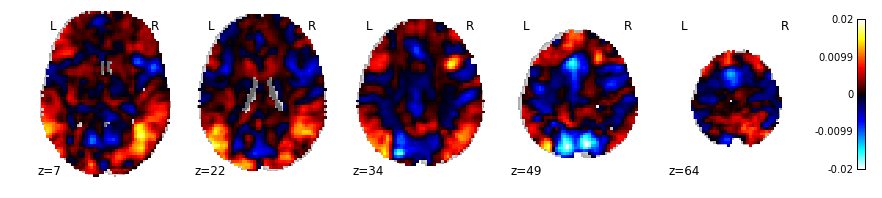

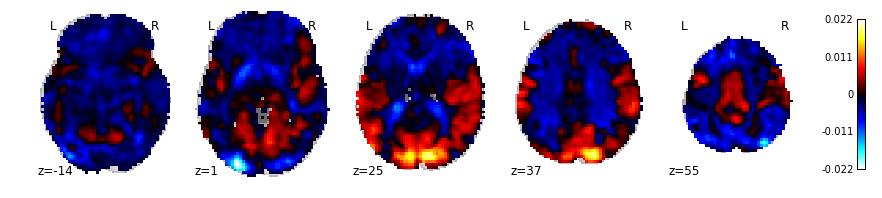

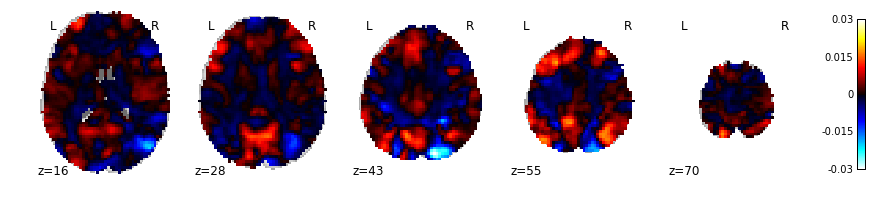

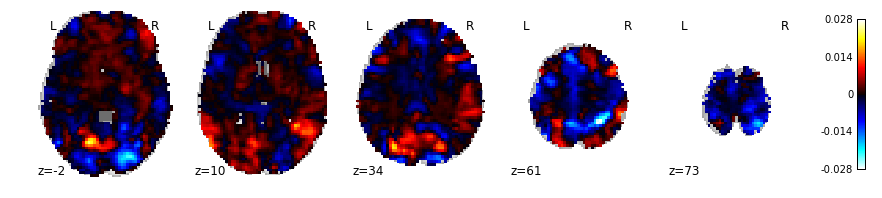

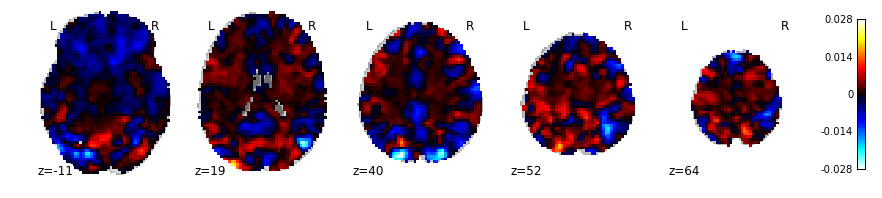

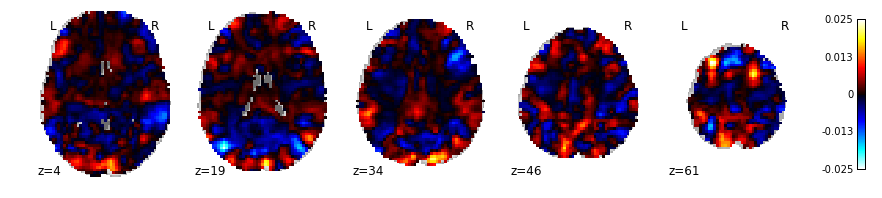

In [26]:
# Visualizing the componenets of the images (cluster on the right)

path = pjoin(results_folder, 'pca_k_1.pkl')
niimgs = X[inlier_indices_0][kmeans.labels_ == 1]

if os.path.exists(path):
    pca_k_1 = pk.load(open(path, 'rb'))
    X_pca_k_1 = pca_k_1.transform(niimgs)
else:
    pca_k_1 = PCA(n_components=42)
    X_pca_k_1 = pca_k_1.fit_transform(niimgs)
    pk.dump(pca_k_1, open(path, 'wb'))

for i in range(10):
    plot_stat_map(masker.inverse_transform(pca_k_1.components_[i]), display_mode='z', cut_coords=5)

### Normalization + StandardScaler + PCA ###

In [53]:
# Cleaning the mem
#del X_pca_0, pca_0, X_pca_k_1, niimgs, pca_k_1

from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.decomposition import IncrementalPCA, FastICA
from sklearn.pipeline import make_pipeline

path = pjoin(results_folder, 'pipeline_pca.pkl')

inlier_indices_0 = np.load(pjoin(results_folder, 'inlier_indices_0.npy'))

if os.path.exists(path):
    pipeline_pca = pk.load(open(path, 'rb'))
    X_pipeline_pca = pipeline_pca.transform(X[inlier_indices_0])
else:
    pca_ = IncrementalPCA(n_components=42)
    standard_scaler = StandardScaler()
    pipeline_pca = make_pipeline(Normalizer(), standard_scaler, pca_)
    X_pipeline_pca = pipeline_pca.fit(X[inlier_indices_0])
    pk.dump(pipeline_pca, open(path, 'wb'))

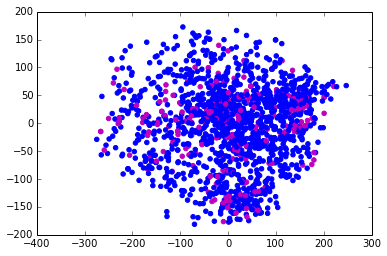

In [54]:
plt.scatter(*X_pipeline_pca[:, :2].T, color=np.array(['b', 'm'])[thresholded_labels])

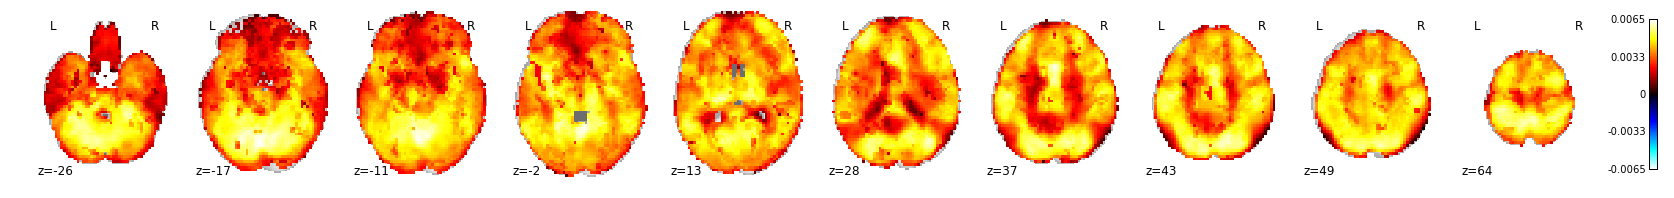

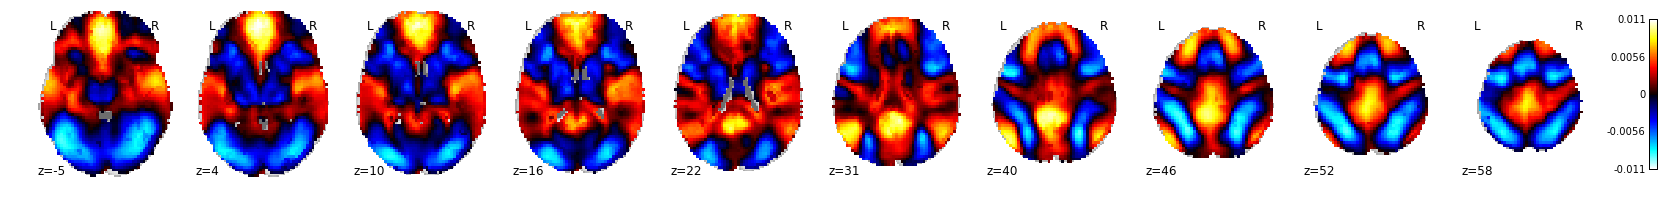

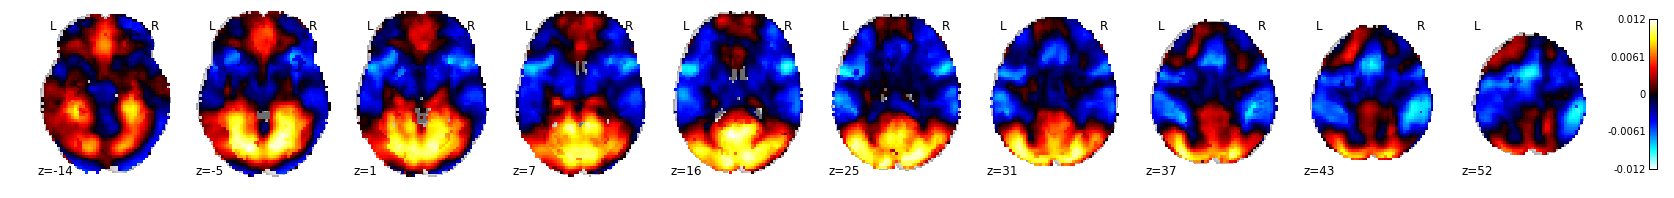

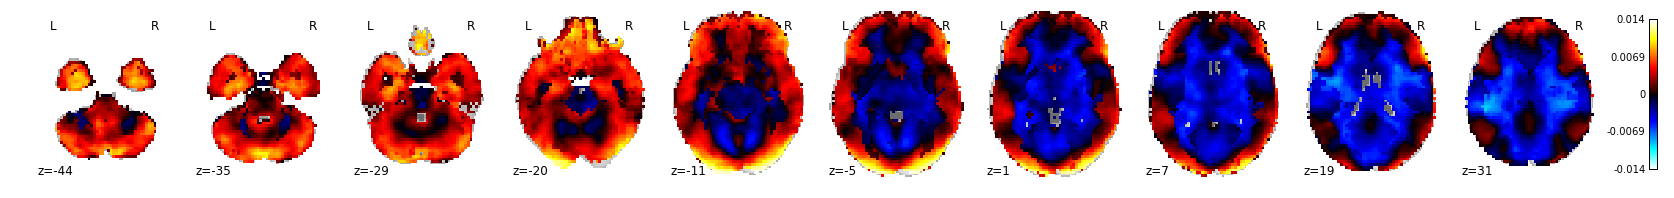

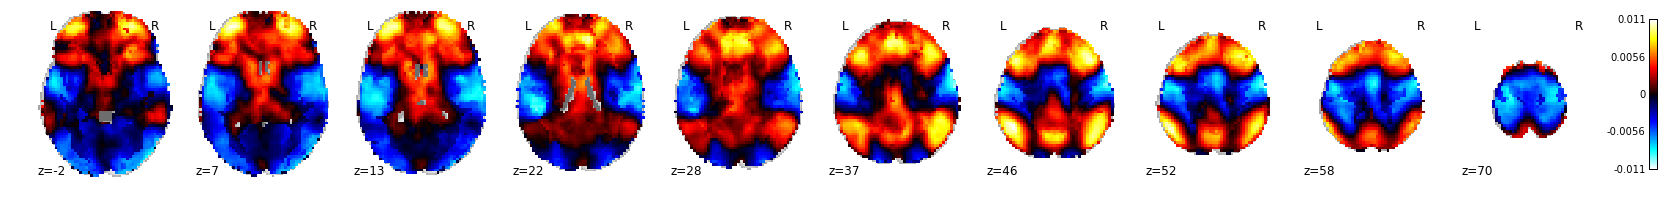

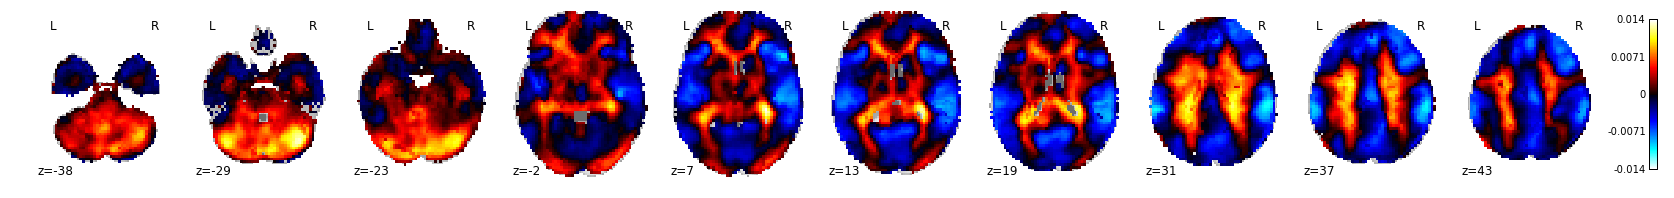

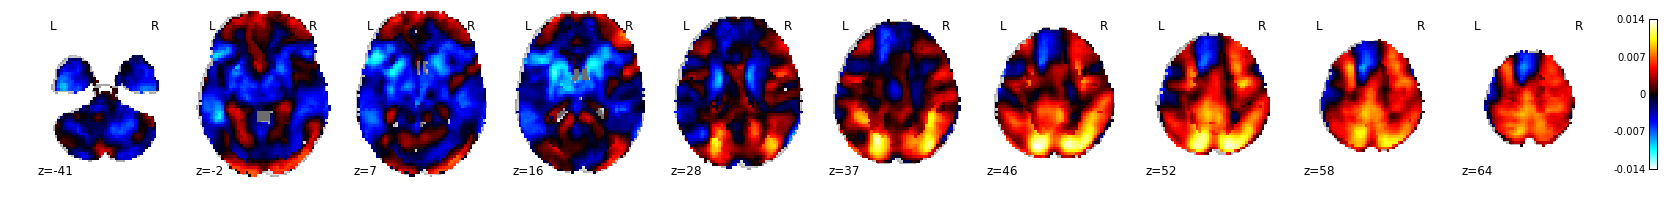

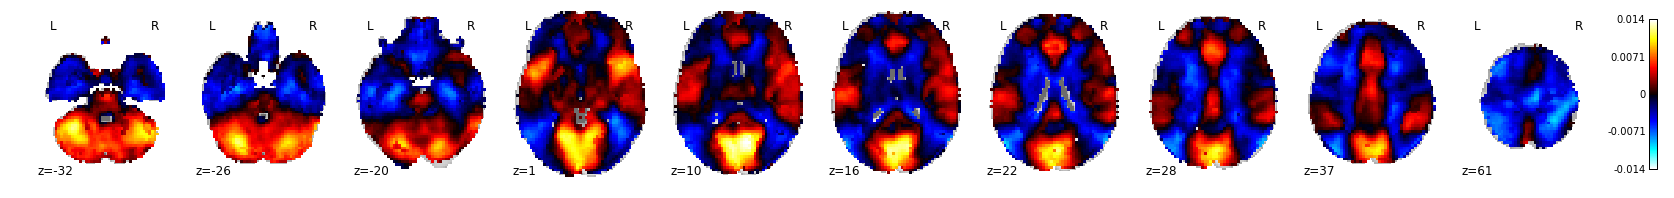

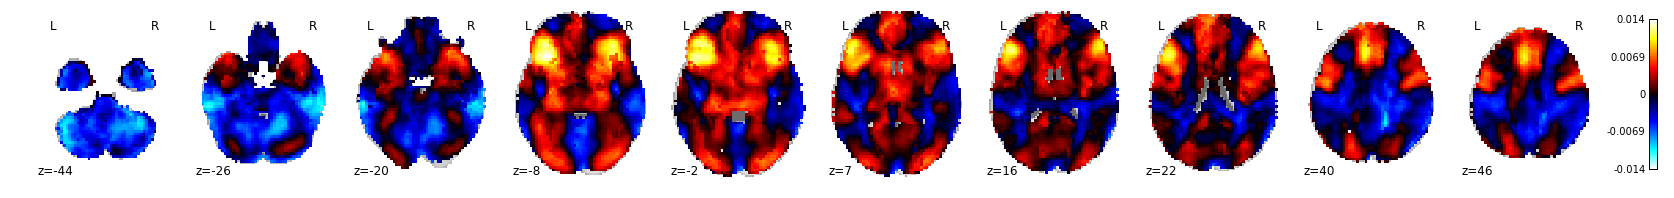

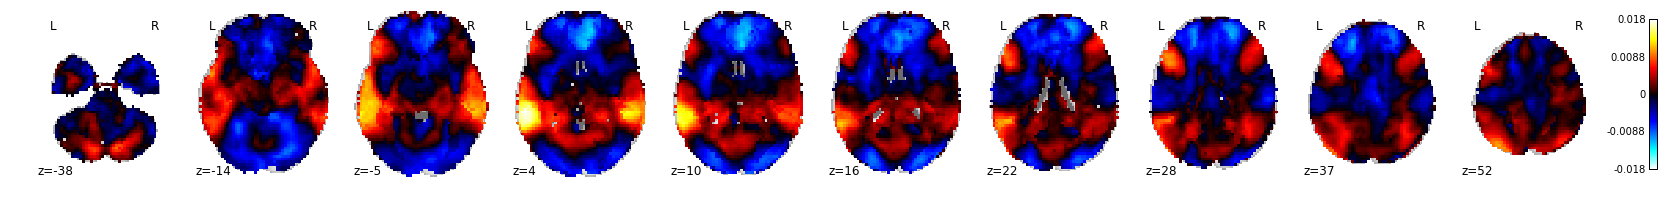

In [55]:
for i in range(10):
    plot_stat_map(masker.inverse_transform(pipeline_pca.steps[2][1].components_[i]), cut_coords=10, display_mode='z')

### Testing the ICA

In [56]:
del  X_pipeline_pca, pipeline_pca

path = pjoin(results_folder, 'pipeline_ica.pkl')

if os.path.exists(path):
    pipeline_ica = pk.load(open(path, 'rb'))
    X_pipeline_ica = pipeline_ica.transform(X[inlier_indices_0])
else:
    fast_ica = FastICA(whiten=True, n_components=42)
    standard_scaler = StandardScaler()
    pipeline_ica = make_pipeline(Normalizer(), standard_scaler, fast_ica)
    X_pipeline_ica = pipeline_ica.fit(X[inlier_indices_0])
    pk.dump(pipeline_ica, open(path, 'wb'))

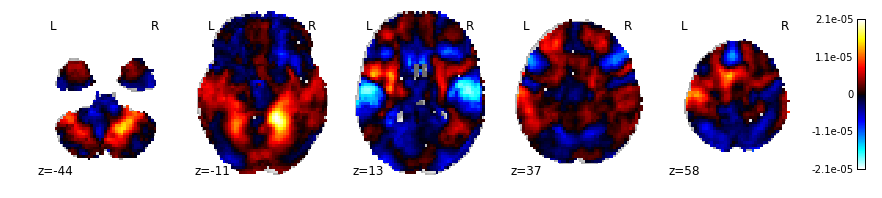

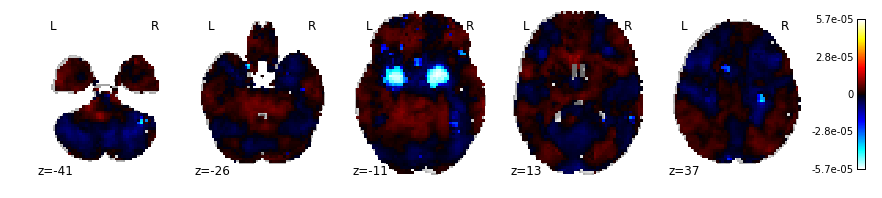

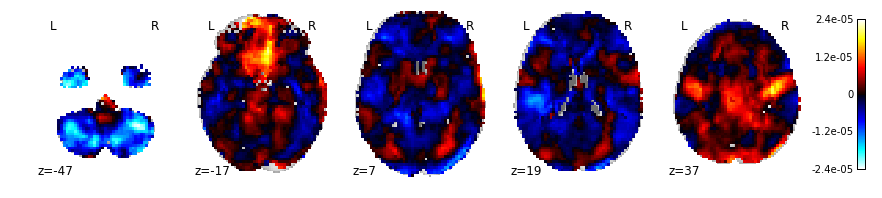

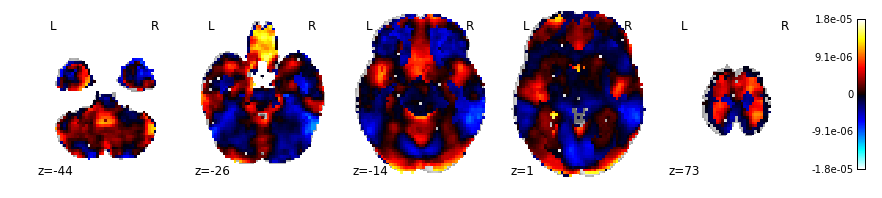

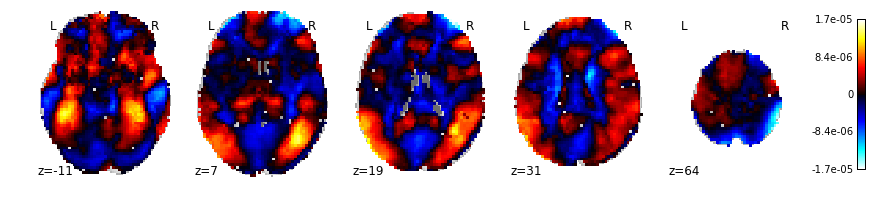

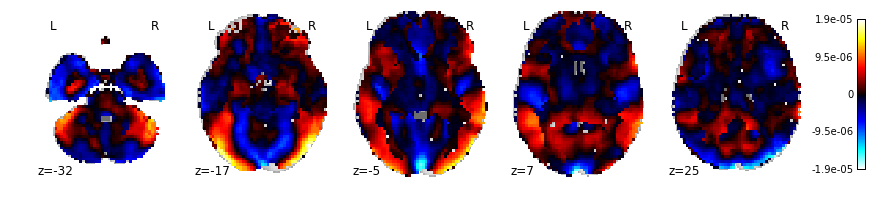

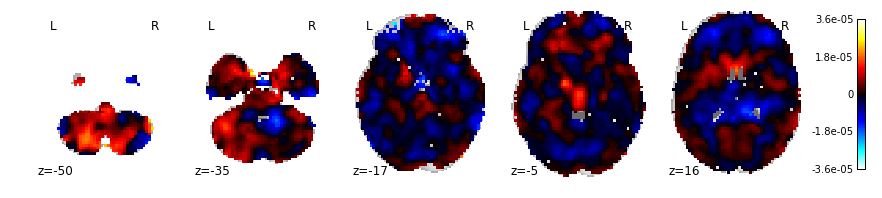

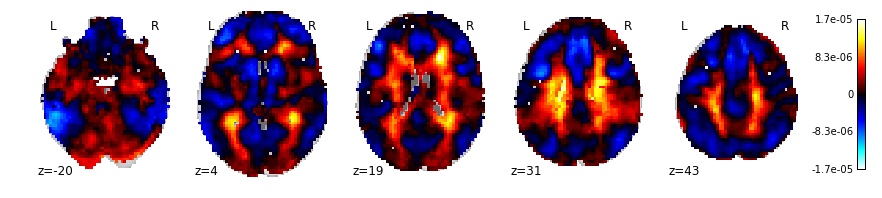

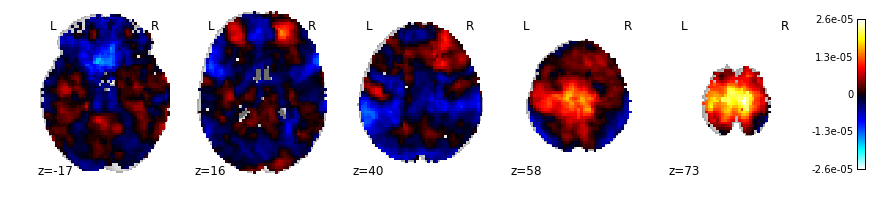

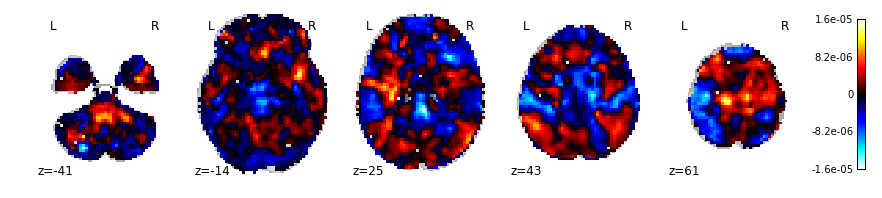

In [58]:
for i in range(10):
    plot_stat_map(masker.inverse_transform(pipeline_ica.steps[2][1].components_[i]), display_mode='z', 
                  cut_coords=5, threshold=1e-8)

### Dictionary Learning  and CanICA###

In [59]:
del pipeline_ica, X_pipeline_ica

n_components = 42
memory = 'nilearn_cache'
canica = CanICA(n_components=n_components, memory=memory, memory_level=2, threshold=3.,
                n_init=1, verbose=1)
dict_learning = DictLearning(n_components=n_components, memory=memory, memory_level=2,
                             verbose=1, random_state=0, n_epochs=1)

In [62]:
X_canica = canica.fit_transform(X[inlier_indices_0])

[MultiNiftiMasker.fit] Loading data from [[-0.22941632568836212, 0.16705599427223206, 0.75054353475570679, -0.41589069366455078, 0.11467462033033371, -1.1246535778045654, -1.080418586730957, -0.12276555597782135, -0.39181697368621826, -1.467
[MultiNiftiMasker.fit] Computing mask
________________________________________________________________________________
[Memory] Calling nilearn.masking.compute_multi_epi_mask...
compute_multi_epi_mask(array([[ -2.294163e-01, ...,  -4.358359e-01],
       ..., 
       [  1.215936e-02, ...,  -1.748767e-04]]), target_shape=None, target_affine=None, n_jobs=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________________________________________
[Memory] Calling nilearn.image.image._compute_mean...
_compute_mean(array([-0.229416, ..., -0.435836]), target_shape=None, target_affine=None, smooth=1)


TypeError: Data given cannot be loaded because it is not compatible with nibabel format:
-0.22941632568836212

In [ ]:
for i in range(10):
    plot_stat_map(masker.inverse_transform(X_canica.components_[i]), cut_coords=10, display_mode='z')